In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy

In [45]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

In [54]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images).item(), torch.max(images).item())

0.0 1.0


In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(), 
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # N, 64, 7, 1, 1
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Note: [-1, 1] -> nn.Tanh
# nn.MaxPool2d -> nn.MaxUnpool2d

In [5]:
class AutoEncoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 28, 28
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128), # N, 28x28 -> N, 128
            nn.ReLU(), 
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3), # -> N, 3
            )

        self.decoder = nn.Sequential(
            nn.Linear(3, 12), 
            nn.ReLU(), 
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28), 
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Note: [-1, 1] -> nn.Tanh

In [9]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [16]:
num_epochs = 1
outputs: list[tuple[int, any, any]] = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        # img = img.reshape(-1, 28*28)
        recon = model(img)
        loss = criterion(recon, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
    outputs.append((epoch, img, recon))

Epoch: 1, Loss: 0.0049


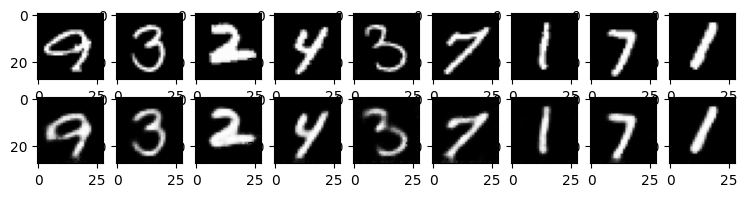

In [11]:
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    _, img, recon = outputs[k]
    imgs  = img.detach().numpy()
    recon = recon.detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28)
        plt.imshow(item[0])
    
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        # item = item.reshape(-1, 28, 28)
        plt.imshow(item[0])

Text(0.5, 1.0, 'Reconstructed')

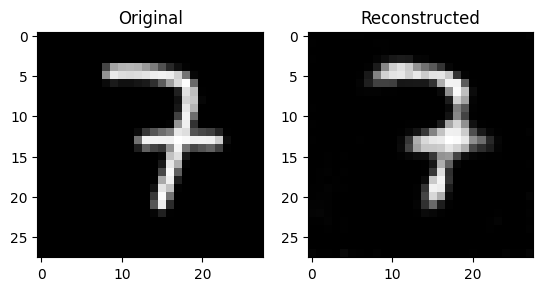

In [90]:

a = Image.open(input("image path: ")).convert('L')
# plt.imshow(numpy.asarray(a))
transformed = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])(a)
model = model.eval()
output = model(transformed)
plt.subplot(1, 2, 1)
plt.imshow(numpy.asarray(a)) # original
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(output[0].detach().numpy()) # reconstructed
plt.title("Reconstructed")
